https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [185]:
ls

RNN_prep.ipynb
RNN_prep_test_train_separately_scaled.ipynb
Untitled.ipynb
rnn_data_prajwal.csv


In [186]:
df = pd.read_csv('rnn_data_prajwal.csv', parse_dates=['DateTime'], index_col='DateTime')

In [187]:
df.head()

,Unnamed: 0,Fc,Ta,Ws,Fg,VPD,Fn,q,Ts,Sws
DateTime,,,,,,,,,,
2013-01-01 01:00:00,1,3.070399,26.998711,2.08,-20.984654,1.183521,-39.635899,0.014801,32.291790,0.032662
2013-01-01 01:30:00,2,2.948313,26.629910,2.47,-19.131921,1.067606,-35.979652,0.015045,32.036301,0.032636
2013-01-01 02:00:00,3,2.369790,26.294310,1.95,-18.278720,1.002275,-38.033844,0.015030,31.798710,0.032619
2013-01-01 02:30:00,4,0.105580,25.739479,1.55,-17.862080,0.927464,-41.878986,0.014810,31.572710,0.032582
2013-01-01 03:30:00,6,2.085828,24.548740,2.69,-21.647482,0.792163,-57.483334,0.014242,31.069750,0.032534


In [188]:
df.keys()

Index(['Unnamed: 0', 'Fc', 'Ta', 'Ws', 'Fg', 'VPD', 'Fn', 'q', 'Ts', 'Sws'], dtype='object')

In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9015 entries, 2013-01-01 01:00:00 to 2014-01-01 00:00:00
Data columns (total 10 columns):
Unnamed: 0    9015 non-null int64
Fc            9015 non-null float64
Ta            9015 non-null float64
Ws            9015 non-null float64
Fg            9015 non-null float64
VPD           9015 non-null float64
Fn            9015 non-null float64
q             9015 non-null float64
Ts            9015 non-null float64
Sws           9015 non-null float64
dtypes: float64(9), int64(1)
memory usage: 774.7 KB


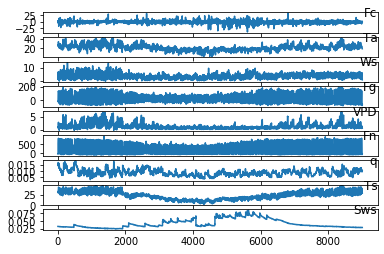

In [190]:
values = df.values
# specify columns to plot
groups = [1, 2, 3, 4, 5, 6, 7, 8, 9]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [191]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [192]:
Xvar = ['Ta', 'Ws', 'Fg', 'VPD', 'Fn', 'q', 'Ts', 'Sws']
yvar = 'Fc'

### Classical fit with random test/train split

In [193]:
X_train, X_test, y_train, y_test = train_test_split(df[Xvar], df[yvar], 
                                                    test_size=0.33, random_state=42)

In [194]:
scaler = StandardScaler()
Xtrain = scaler.fit_transform(X_train[Xvar])
reg = LinearRegression().fit(Xtrain, y_train)

Xtest = scaler.fit_transform(X_test[Xvar])
y_pred = reg.predict(Xtest)

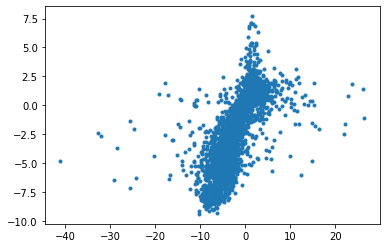

In [195]:
plt.plot(y_test, y_pred, '.')

In [196]:
mean_squared_error(y_test, y_pred)

11.266022762352394

### LSTM 

#### Data preparation

In [197]:
from sklearn.preprocessing import MinMaxScaler

In [198]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [199]:
df[Xvar + [yvar]].head()

,Ta,Ws,Fg,VPD,Fn,q,Ts,Sws,Fc
DateTime,,,,,,,,,
2013-01-01 01:00:00,26.998711,2.08,-20.984654,1.183521,-39.635899,0.014801,32.291790,0.032662,3.070399
2013-01-01 01:30:00,26.629910,2.47,-19.131921,1.067606,-35.979652,0.015045,32.036301,0.032636,2.948313
2013-01-01 02:00:00,26.294310,1.95,-18.278720,1.002275,-38.033844,0.015030,31.798710,0.032619,2.369790
2013-01-01 02:30:00,25.739479,1.55,-17.862080,0.927464,-41.878986,0.014810,31.572710,0.032582,0.105580
2013-01-01 03:30:00,24.548740,2.69,-21.647482,0.792163,-57.483334,0.014242,31.069750,0.032534,2.085828


In [200]:
df[Xvar + [yvar]].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9015 entries, 2013-01-01 01:00:00 to 2014-01-01 00:00:00
Data columns (total 9 columns):
Ta     9015 non-null float64
Ws     9015 non-null float64
Fg     9015 non-null float64
VPD    9015 non-null float64
Fn     9015 non-null float64
q      9015 non-null float64
Ts     9015 non-null float64
Sws    9015 non-null float64
Fc     9015 non-null float64
dtypes: float64(9)
memory usage: 704.3 KB


In [296]:
#scaler_inst = MinMaxScaler(feature_range=(0,1))
def scale_features(idf, yvar, xvar, scaler_inst):
    scaled = scaler.fit_transform(idf[yvar + xvar])

    # frame as supervised learning
    reframed = series_to_supervised(scaled, 1, 1)
    
    # Number of x and y features
    nxy = idf.shape[1]
    
    # As we only want to predict y(t) i.e. var1(t) drop all other (t) terms
    reframed.drop(reframed.keys()[nxy:], axis=1, inplace=True)
    
    print('Reframed: ', reframed.shape, 'df', idf.shape)
    print(reframed.head())

    return reframed

### Train/test preparation

In [311]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24

train_df = df.iloc[:n_train_hours]
test_df = df.iloc[n_train_hours:]

print(train_df.shape, test_df.shape)

(8760, 10) (255, 10)


In [318]:
# Scaling training set
scaler_inst = StandardScaler()
reframed_train = scale_features(train_df, [yvar], Xvar, scaler_inst)

# Scaling test set
scaler_inst = StandardScaler()
test_df = pd.DataFrame(scaler_inst.fit_transform(test_df[Xvar]), columns=Xvar)
print(test_df.shape)

Reframed:  (8759, 10) df (8760, 10)
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   1.074316   0.746103  -1.127272  -0.791189  -0.291165  -1.045799   
2   1.048060   0.684029  -0.887748  -0.759543  -0.394719  -1.032302   
3   0.923639   0.627543  -1.207114  -0.744970  -0.453083  -1.039885   
4   0.436683   0.534158  -1.452779  -0.737853  -0.519918  -1.054079   
5   0.862568   0.333742  -0.752632  -0.802511  -0.640791  -1.111682   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   2.612014   0.957753  -0.683231  1.048060  
2   2.714835   0.930772  -0.685142  0.923639  
3   2.708731   0.905680  -0.686383  0.436683  
4   2.616024   0.881813  -0.688997  0.862568  
5   2.376905   0.828697  -0.692480  0.385500  
(255, 8)


In [300]:
# split into train and test sets
values = reframed_train.values
train = values[:n_train_hours, :]
print(train.shape)

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
print(train_X.shape, train_y.shape)

(8759, 10)
(8759, 1, 9) (8759,)


### Training

In [209]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error

Epoch 1/50
 - 3s - loss: 0.5605
Epoch 2/50
 - 1s - loss: 0.3962
Epoch 3/50
 - 1s - loss: 0.3837
Epoch 4/50
 - 1s - loss: 0.3753
Epoch 5/50
 - 1s - loss: 0.3711
Epoch 6/50
 - 1s - loss: 0.3688
Epoch 7/50
 - 1s - loss: 0.3675
Epoch 8/50
 - 1s - loss: 0.3659
Epoch 9/50
 - 1s - loss: 0.3645
Epoch 10/50
 - 1s - loss: 0.3631
Epoch 11/50
 - 1s - loss: 0.3621
Epoch 12/50
 - 1s - loss: 0.3609
Epoch 13/50
 - 1s - loss: 0.3601
Epoch 14/50
 - 1s - loss: 0.3589
Epoch 15/50
 - 1s - loss: 0.3578
Epoch 16/50
 - 1s - loss: 0.3569
Epoch 17/50
 - 1s - loss: 0.3559
Epoch 18/50
 - 1s - loss: 0.3546
Epoch 19/50
 - 1s - loss: 0.3541
Epoch 20/50
 - 1s - loss: 0.3532
Epoch 21/50
 - 1s - loss: 0.3525
Epoch 22/50
 - 1s - loss: 0.3517
Epoch 23/50
 - 1s - loss: 0.3511
Epoch 24/50
 - 1s - loss: 0.3500
Epoch 25/50
 - 1s - loss: 0.3492
Epoch 26/50
 - 1s - loss: 0.3486
Epoch 27/50
 - 1s - loss: 0.3477
Epoch 28/50
 - 1s - loss: 0.3472
Epoch 29/50
 - 1s - loss: 0.3467
Epoch 30/50
 - 1s - loss: 0.3460
Epoch 31/50
 - 1s -

KeyError: 'val_loss'

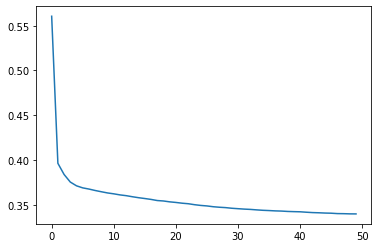

In [302]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, #validation_data=(test_X, test_y), 
                    verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [320]:
# make a prediction
yhat = model.predict(test_df)

ValueError: Error when checking input: expected lstm_9_input to have 3 dimensions, but got array with shape (255, 8)

In [234]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# calculate RMSE
rmse_dl = np.sqrt(mean_squared_error(test_df.iloc[1:][yvar], inv_yhat))
print('Test RMSE: %.3f' % rmse_dl)

Test RMSE: 1.674


### Classical Fit

In [ ]:
df.shape

In [ ]:
print("DL train size", train_X.shape[0], "Classical train size", df.iloc[:train_X.shape[0]].shape[0])

In [ ]:
train = df.iloc[:train_X.shape[0]]
test = df.iloc[train_X.shape[0]:]

#### Linear Regression

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
Xtrain = scaler.fit_transform(train[Xvar])
reg = LinearRegression().fit(Xtrain, train[yvar])

Xtest = scaler.fit_transform(test[Xvar])
y_pred_linreg = reg.predict(Xtest)

#### Random Forrest

In [ ]:
from sklearn.ensemble import RandomForestRegressor as RFE

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
Xtrain = scaler.fit_transform(train[Xvar])
reg = RFE(n_estimators=500, 
         max_depth = 10, n_jobs=-1).fit(Xtrain, train[yvar])

Xtest = scaler.fit_transform(test[Xvar])
y_pred_rfe = reg.predict(Xtest)

### Diagnostic Report/Plot

In [ ]:
plt.plot(test[yvar], y_pred_linreg, '.', label='Linear Reg')
plt.plot(test[yvar], y_pred_rfe, '.', label='RF Reg', alpha=0.6)
plt.plot(inv_y, inv_yhat, 'g.', label='LSTM', alpha=0.3)
plt.plot([-10,15], [-10,15], '--k')
plt.xlabel('Yobs')
plt.ylabel('Ypred')
plt.legend()
print("RMSE linear reg: ", np.sqrt(mean_squared_error(test[yvar], y_pred_linreg)))
print("RMSE RF reg: ", np.sqrt(mean_squared_error(test[yvar], y_pred_rfe)))
print("RMSE LSTM: ", rmse_dl)

In [ ]:
plt.plot(test[yvar], y_pred_linreg, '.', label='Linear Reg')
plt.plot(test[yvar], y_pred_rfe, '.', label='RF Reg', alpha=0.6)
plt.plot(inv_y, inv_yhat, 'g.', label='LSTM', alpha=0.3)
plt.plot([-10,15], [-10,15], '--k')
plt.xlabel('Yobs')
plt.ylabel('Ypred')
plt.legend()
print("RMSE linear reg: ", np.sqrt(mean_squared_error(test[yvar], y_pred_linreg)))
print("RMSE RF reg: ", np.sqrt(mean_squared_error(test[yvar], y_pred_rfe)))
print("RMSE LSTM: ", rmse_dl)